**Install and Load pckgs**

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install transformers

In [ ]:
import pandas as pd
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from networkx.algorithms import centrality, cluster
import copy
import torch
import gc
from tqdm.auto import tqdm
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
from scipy.linalg import eigh
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from operator import itemgetter
from itertools import count
from scipy import stats
%matplotlib inline

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Load the Data:**


*   bond_dict - list of the bonds type names (edges).
*   atom_dict - list of the atoms type names (nodes).
*   zinc12k - list of 12k ZINC molecule as DGL graphs.

In [3]:
bond_dict = torch.load("bond_dict.pt")
atom_dict = torch.load("atom_dict.pt")
zinc12k = torch.load("zinc12k.pt")

An illustration of a molecule graph sample:

In [8]:
graph, label = zinc12k[0]
print(graph.ndata['feat'])
print(graph.edata['feat'])
print(graph.edges())

tensor([ 1, 17,  1,  1,  1, 22,  1,  5, 26,  1,  1,  3,  1,  1,  1,  1, 13,  1,
        13,  1,  1,  5,  1,  1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 1, 2, 2,
        1, 1, 1, 1])
(tensor([ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  6,  7,  8,
         8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 15, 15,
        15, 16, 17, 17, 17, 18, 19, 19, 20, 20, 20, 21, 22, 22, 23, 23]), tensor([ 1,  0,  2, 23,  1,  3,  2,  4,  3,  5, 22,  4,  6,  5,  7,  8,  6,  6,
         9, 20,  8, 10,  9, 11, 10, 12, 20, 11, 13, 19, 12, 14, 13, 15, 14, 16,
        17, 15, 15, 18, 19, 17, 12, 17,  8, 11, 21, 20,  4, 23,  1, 22]))


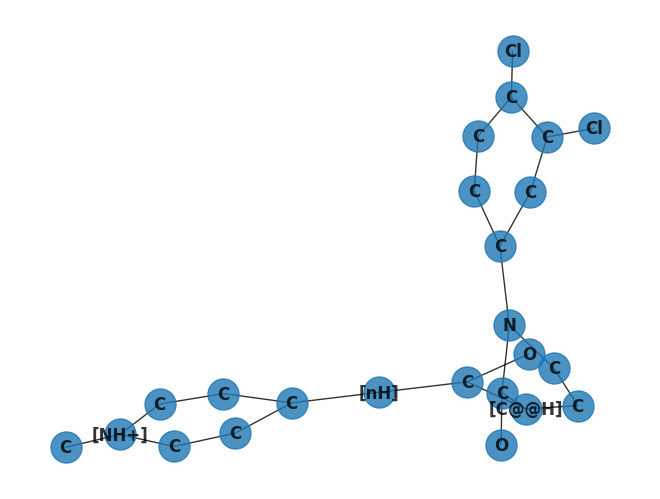

In [6]:
# Convert this DGLGraph to an undirected NetworkX graph
nx_graph = graph.to_networkx(node_attrs=['feat'], edge_attrs=['feat'])
undirected_graph = nx_graph.to_undirected()
G = nx.Graph(undirected_graph)

# Create a dictionary mapping node IDs to their labels(atom types)
labels_dict = {i: atom_dict[label] for i, label in enumerate(graph.ndata['feat'].tolist())}

# Set the node attributes for the NetworkX graph
nx.set_node_attributes(G, labels_dict, 'feat')

# Draw the networkx graph with labels
pos = nx.spring_layout(G)  # compute graph layout
nx.draw(G, pos, labels=nx.get_node_attributes(G, 'feat'), with_labels=True, node_size=600, alpha=0.8, font_weight='bold')
plt.show()

We begin by transforming each DGL (Deep Graph Library) graph into an undirected NetworkX graph. Then, we convert each graph into a sequence representation by traversing the graph, from the first node to the last. During this traversal, we use the labels of nodes and edges to narratively describe the path taken. This process effectively translates the graph structures into sequences that can be further analyzed or processed.

In [9]:
results = [] # list to store the graph sequences with the labels

for graph, label in zinc12k:
    # Convert this DGLGraph to an undirected NetworkX graph
    nx_graph = graph.to_networkx(node_attrs=['feat'], edge_attrs=['feat'])
    undirected_graph = nx_graph.to_undirected()
    G = nx.Graph(undirected_graph)

    # Create a dictionary mapping node IDs to their labels
    node_labels_dict = {i: f'{i}: {atom_dict[label]}' for i, label in enumerate(graph.ndata['feat'].tolist())}

    # Create a dictionary mapping edge to their labels
    edge_labels_dict = {(i, j): bond_dict[label-1] for i, j, label in zip(graph.edges()[0].tolist(), graph.edges()[1].tolist(), graph.edata['feat'].tolist())}

    # Set the node and edge attributes for the NetworkX graph
    nx.set_node_attributes(G, node_labels_dict, 'feat')
    nx.set_edge_attributes(G, edge_labels_dict, 'feat')

    # Get edges with data as a list
    edge_list = list(G.edges(data=True))

    # Sort the edges by 'id' attribute
    edges_sorted = sorted(edge_list, key=lambda x: x[2]['id'])

    graph_tokens_list = []
    # Now iterate through the sorted edges
    for idx, (u, v, data) in enumerate(edges_sorted):
        node0 = nx.get_node_attributes(G, 'feat')[u].split(": ")[1]
        node1 = nx.get_node_attributes(G, 'feat')[v].split(": ")[1]
        edge_type = data['feat']

        if idx == len(edges_sorted) - 1: # if this is the last iteration
            graph_token = f"[{node0}][{edge_type}][{node1}]"
        else:
            graph_token = f"[{node0}][{edge_type}]"

        graph_tokens_list.append(graph_token)


    # Combine all graph tokens into a single string for the graph
    graph_sequence = "".join(graph_tokens_list)

    result = {
        'graph_sequence': graph_sequence,
        'logP': label.item(),  # Get the scalar value from the tensor
    }
    results.append(result)

# Convert the results to a pandas DataFrame
zinc_dataset = pd.DataFrame(results)

In [10]:
zinc_dataset.head()

,graph_sequence,logP
0,[C][SINGLE][[NH+]][SINGLE][C][SINGLE][C][SINGL...,1.13960
1,[C][SINGLE][[C@@H]][SINGLE][[C@@H]][SINGLE][C]...,0.34360
2,[C][SINGLE][C][AROMATIC][C][AROMATIC][C][AROMA...,4.85712
3,[C][DOUBLE][C][SINGLE][C][SINGLE][C][AROMATIC]...,2.34040
4,[C][SINGLE][[C@@H]][SINGLE][C][AROMATIC][N][AR...,4.10500


In [13]:
zinc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   graph_sequence  12000 non-null  object 
 1   logP            12000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 187.6+ KB


**Dataset Basic Statistics:**

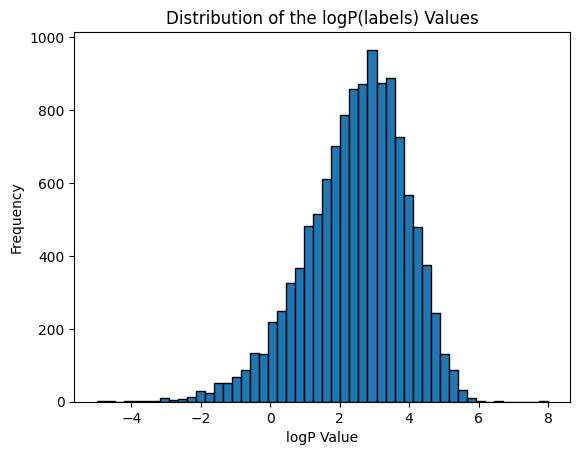

In [11]:
plt.hist(zinc_dataset['logP'], bins=50, edgecolor='black')

plt.title('Distribution of the logP(labels) Values')
plt.xlabel('logP Value')
plt.ylabel('Frequency')

plt.show()

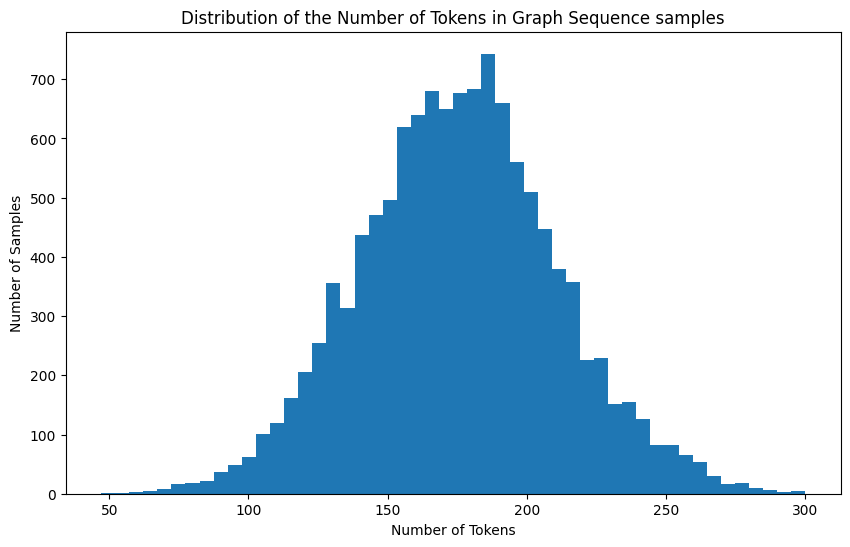

In [12]:
# from transformers import AutoTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Compute the number of tokens in each text
num_tokens = [len(tokenizer.encode(text)) for text in zinc_dataset['graph_sequence']]

# Create a histogram of the number of tokens
plt.figure(figsize=(10, 6))
plt.hist(num_tokens, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Samples')
plt.title('Distribution of the Number of Tokens in Graph Sequence samples')
plt.show()

Train/Validation/Test splits:

We divide the total of 12,000 samples into different subsets for training, validation, and testing, following the distribution used in the paper "A Generalization of Transformer Networks to Graphs". Specifically, we allocate 10,000 samples for training purposes, while the remaining 2,000 samples are evenly split into two sets of 1,000 each for validation and testing.

In [14]:
from sklearn.model_selection import train_test_split

# First spliting the data into train+valid and test
zinc12k_train_valid, zinc12k_test = train_test_split(zinc_dataset, test_size=1000, shuffle=True, random_state=42)

# Then split the train+valid data into train and valid
zinc12k_train, zinc12k_valid = train_test_split(zinc12k_train_valid, train_size=10000, shuffle=True, random_state=42)

zinc12k_train.reset_index(inplace=True, drop=True)
zinc12k_valid.reset_index(inplace=True, drop=True)
zinc12k_test.reset_index(inplace=True, drop=True)

As part of our evaluation strategy, we not only benchmark our approach against the results from the study "A Generalization of Transformer Networks to Graphs" but also contrast it with a very basic model utilizing mean or median baseline predictions. This rudimentary model disregards any input information, offering a prediction that is simply the mean or median of the training set's target variable. Despite its simplicity, this model establishes a basic performance threshold that any effective model should surpass. Any model unable to outperform this basic approach is likely overfitting the training set without successfully identifying and learning useful patterns.

In [15]:
mean_label = zinc12k_train['logP'].mean()
median_label = zinc12k_train['logP'].median()

# Create arrays with the size of the validation/test sets filled with the mean/median
mean_preds = np.full_like(zinc12k_valid['logP'], fill_value=mean_label)
median_preds = np.full_like(zinc12k_valid['logP'], fill_value=median_label)

# Compute MAE for the mean and median baselines
mean_mae = mean_absolute_error(zinc12k_valid['logP'], mean_preds)
median_mae = mean_absolute_error(zinc12k_valid['logP'], median_preds)

print(f"Mean baseline MAE: {mean_mae}")
print(f"Median baseline MAE: {median_mae}")

Mean baseline MAE: 1.1126935442850951
Median baseline MAE: 1.105254319530679


This script below defines the main training, validation, and testing pipeline for a text classification task using the Longformer model from Hugging Face's Transformers library.

It begins by defining a custom PyTorch Dataset that accepts the text data, labels, a tokenizer, and a maximum sequence length as inputs. The text is tokenized and encoded into input IDs and attention masks using the Longformer tokenizer.

The Longformer model is then loaded and prepared for training. Key training parameters are set, including the number of epochs (10) , batch size (8), and the leaning rate (5e-5). The data loaders for the training, validation, and testing datasets are also prepared.

The training loop involves the forward pass, the computation of the loss, and the backward pass for gradient computation. After a certain number of steps (4, as defined by the gradient accumulation parameter), the model's parameters are updated.

After each epoch of training, the model is switched to evaluation mode and the Mean Absolute Error (MAE) on the validation set is calculated.

Once the training process is complete, the final model is evaluated on the test set, and the Mean Absolute Error (MAE) on the test data is reported.

Throughout the process, memory is periodically cleared to maintain efficiency.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Load tokenizer and model
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=1)

# Training parameters
epochs = 10
batch_size = 8
grad_acc_steps = 4  # Update the model every grad_acc_steps batches
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create data loaders
train_data = TextDataset(zinc12k_train['graph_sequence'], zinc12k_train['logP'], tokenizer, max_len=300)
val_data = TextDataset(zinc12k_valid['graph_sequence'], zinc12k_valid['logP'], tokenizer, max_len=300)
test_data = TextDataset(zinc12k_test['graph_sequence'], zinc12k_test['logP'], tokenizer, max_len=300)

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Move model to device and specify optimizer
model = model.to(device)
optim = AdamW(model.parameters(), lr=5e-5)

# Variables to store per-epoch metrics
train_loss_values = []
val_mae_values = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Update total loss
        loss.backward()

        # Gradient accumulation
        if (i + 1) % grad_acc_steps == 0 or i == len(train_loader) - 1:
            optim.step()
            optim.zero_grad()
            gc.collect()  # Run garbage collector to free up memory
            torch.cuda.empty_cache()  # Free up memory

    # After the training, save the model
    model_save_name = 'zinc_longformer_model.pth'
    path = F"/content/gdrive/My Drive/{model_save_name}"
    torch.save(model.state_dict(), path)

    # After the end of each epoch, compute the average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(outputs.logits.squeeze().detach().cpu().numpy())
            true.extend(labels.cpu().numpy())
            gc.collect()  # Run garbage collector to free up memory
            torch.cuda.empty_cache()  # Free up memory
    val_mae = mean_absolute_error(true, preds)
    val_mae_values.append(val_mae)
    print(f'Epoch: {epoch}, MAE: {mean_absolute_error(true, preds)}')

# Test
model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds.extend(outputs.logits.squeeze().detach().cpu().numpy())
        true.extend(labels.cpu().numpy())
print(f'Test MAE: {mean_absolute_error(true, preds)}')

In [ ]:
# plot the training loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values)
plt.title('Training Loss as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
# plot the validation MAE values
plt.figure(figsize=(10, 5))
plt.plot(val_mae_values)
plt.title('Validation MAE as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
# #load it from Google Drive:
# model_save_name = 'zinc_longformer_model.pth'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=1)
# model.load_state_dict(torch.load(path))